# Sea Level Anomaly Interpolation Using GPSat (GPOD)

This notebook demonstrates the process of using **GPSat** for spatio-temporal interpolation of **Sea Level Anomaly (SLA)** data.

The methodology follows the same processing pipeline used for along-track interpolation. However, instead of focusing on individual tracks, we extend the approach to all available tracks, aiming to fill gaps between them. Additionally, we define the prediction locations to cover the entire **Arctic region**, ensuring comprehensive spatial coverage.

By leveraging GPSat, we can enhance SLA data completeness and improve our understanding of sea level variations in the Arctic.

## Loading dataset and installing dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:

    import os
    import re

    # change to working directory
    work_dir = "/content"

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

Cloning into 'GPSat'...
remote: Enumerating objects: 2873, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 2873 (delta 143), reused 253 (delta 139), pack-reused 2601 (from 1)
Receiving objects: 100% (2873/2873), 59.92 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
changing directory to: /content/GPSat


In [2]:
if IN_COLAB:
    !pip install -r requirements.txt

Ignoring setuptools: markers 'python_version >= "3.12"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
INFO: pip is looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requireme

In [3]:
if IN_COLAB:
    !pip install -e .

Obtaining file:///content/GPSat
  Preparing metadata (setup.py) ... done
  Running setup.py develop for GPSat


In [4]:
import os
import re
import glob
import numpy as np
import pandas as pd
import warnings
# warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from datetime import datetime, timedelta
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.postprocessing import smooth_hyperparameters
import GPSat
from GPSat.postprocessing import glue_local_predictions_1d
from GPSat.postprocessing import glue_local_predictions_2d

In [7]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Transformer

# Go from long,lat to x, y
# Define the transformation function
def WGS84toEASE2_Vectorized(lon, lat, return_vals="both", lon_0=0, lat_0=90):
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(WGS84, EASE2)
    x, y = transformer.transform(lon, lat)
    if return_vals == 'both':
        return x, y

# Go from x,y to long,lat
def EASE2toWGS84(x, y, return_vals="both", lon_0=0, lat_0=90):

    valid_return_vals = ['both', 'lon', 'lat']
    assert return_vals in ['both', 'lon', 'lat'], f"return_val: {return_vals} is not in valid set: {valid_return_vals}"
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(EASE2, WGS84)
    lon, lat = transformer.transform(x, y)
    if return_vals == "both":
        return lon, lat
    elif return_vals == "lon":
        return lon
    elif return_vals == "lat":
        return lat

def get_projection(projection=None):

    # projection
    if projection is None:
        projection = ccrs.NorthPolarStereo()
    elif isinstance(projection, ccrs.Projection):
        pass
    elif isinstance(projection, str):
        if re.search("north", projection, re.IGNORECASE):
            projection = ccrs.NorthPolarStereo()
        elif re.search("south", projection, re.IGNORECASE):
            projection = ccrs.SouthPolarStereo()
        else:
            raise NotImplementedError(f"projection provide as str: {projection}, not implemented")

    return projection

def plot_pcolormesh(ax, lon, lat, plot_data,
                    fig=None,
                    title=None,
                    vmin=None,
                    vmax=None,
                    qvmin=None,
                    qvmax=None,
                    cmap='YlGnBu_r',
                    cbar_label=None,
                    scatter=False,
                    extent=None,
                    ocean_only=False,
                    **scatter_args):

    # ax = axs[j]
    ax.coastlines(resolution='50m', color='white')
    ax.add_feature(cfeat.LAKES, color='white', alpha=.5)
    ax.add_feature(cfeat.LAND, color=(0.8, 0.8, 0.8))
    extent = [-180, 180, 60, 90] if extent is None else extent
    ax.set_extent(extent, ccrs.PlateCarree())  # lon_min,lon_max,lat_min,lat_max

    if title:
        ax.set_title(title)

    if ocean_only:
        if globe_mask is None:
            warnings.warn(f"ocean_only={ocean_only}, however globe_mask is missing, "
                          f"install with pip install global-land-mask")
        else:
            is_in_ocean = globe_mask.is_ocean(lat, lon)
            # copy, just to be safe
            plot_data = copy.copy(plot_data)
            plot_data[~is_in_ocean] = np.nan

    if qvmin is not None:
        if vmin is not None:
            warnings.warn("both qvmin and vmin are supplied, only using qvmin")
        assert (qvmin >= 0) & (qvmin <= 1.0), f"qvmin: {qvmin}, needs to be in [0,1]"
        vmin = np.nanquantile(plot_data, q=qvmin)

    if qvmax is not None:
        if vmax is not None:
            warnings.warn("both qvmax and vmax are supplied, only using qvmax")
        assert (qvmax >= 0) & (qvmax <= 1.0), f"qvmax: {qvmax}, needs to be in [0,1]"
        vmax = np.nanquantile(plot_data, q=qvmax)

    if (vmin is not None) & (vmax is not None):
        assert vmin <= vmax, f"vmin: {vmin} > vmax: {vmax}"

    if not scatter:
        s = ax.pcolormesh(lon, lat, plot_data,
                          cmap=cmap,
                          vmin=vmin, vmax=vmax,
                          transform=ccrs.PlateCarree(),
                          linewidth=0,
                          shading="auto",# to remove DeprecationWarning
                          rasterized=True)
    else:
        non_nan = ~np.isnan(plot_data)
        s = ax.scatter(lon[non_nan],
                       lat[non_nan],
                       c=plot_data[non_nan],
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree(),
                       linewidth=0,
                       rasterized=True,
                       **scatter_args)

    if fig is not None:
        cbar = fig.colorbar(s, ax=ax, orientation='horizontal', pad=0.03, fraction=0.03)
        if cbar_label:
            cbar.set_label(cbar_label, fontsize=14)
        cbar.ax.tick_params(labelsize=14)

In [8]:
import pandas as pd

savepath = '/content/drive/MyDrive/GEOL0069/2324/Week 8 2025/'

# Load DataFrame from CSV file
# df = pd.read_csv(savepath+'all_data_01.csv')
GPOD_data = pd.read_csv(savepath+'df_GPOD.csv')

In [24]:
GPOD_data

x             y      t         lon        lat      date  \
0       -3.056178e+06 -1.270463e+06  17907  -67.427184  60.000844  20190111   
1       -3.055943e+06 -1.270243e+06  17907  -67.429148  60.003653  20190111   
2       -3.055707e+06 -1.270022e+06  17907  -67.431112  60.006463  20190111   
3       -3.055472e+06 -1.269801e+06  17907  -67.433077  60.009272  20190111   
4       -3.055236e+06 -1.269580e+06  17907  -67.435042  60.012081  20190111   
...               ...           ...    ...         ...        ...       ...   
1559080 -1.099325e+06  3.126184e+05  17915 -105.874325  79.752732  20190119   
1559081 -1.099022e+06  3.125989e+05  17915 -105.877535  79.755398  20190119   
1559082 -1.098114e+06  3.125402e+05  17915 -105.887172  79.763397  20190119   
1559083 -1.097811e+06  3.125207e+05  17915 -105.890387  79.766064  20190119   
1559084 -1.097509e+06  3.125011e+05  17915 -105.893604  79.768730  20190119   

        class  interpSLA  elevation  SAT  track  
0        lead        NaN     0.4397  S3A      0  
1        lead     0.4207     0.4250  S3A      0  
2        lead     0.4201     0.4296  S3A      0  
3        lead     0.4195     0.4494  S3A      0  
4        lead     0.4190     0.4171  S3A      0  
...       ...        ...        ...  ...    ...  
1559080  floe    -0.0866     0.2087  CS2    653  
1559081  lead        NaN    -0.1044  CS2    653  
1559082  floe        NaN     0.2351  CS2    653  
1559083  floe        NaN     0.3295  CS2    653  
1559084  floe        NaN     0.3016  CS2    653  

[1559085 rows x 11 columns]

In [12]:
from datetime import datetime, timedelta

# Path to your data directory
path = '/content/drive/MyDrive/GEOL0069/2324/Week 8 2025/'

# Initialise an empty DataFrame to hold all data
all_data_df = pd.DataFrame()

# Extract spatial and temporal information
lon = GPOD_data['lon']
lat = GPOD_data['lat']
time = GPOD_data['date']
interpSLA = GPOD_data['interpSLA']

# Convert time to datetime objects
base_time = datetime(2000, 1, 1)
datetimes = np.array([base_time + timedelta(seconds=int(t)) for t in time])

# Convert lon, lat to EASE-2 Grid
transformer = Transformer.from_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
                                    "+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs")
x, y = transformer.transform(lon, lat)

# Create a DataFrame for this file
all_data_df = pd.DataFrame({
    'x': x,
    'y': y,
    't': (pd.to_datetime(datetimes) - pd.Timestamp("1970-01-01")) / pd.Timedelta('1D'),
    'SLA': interpSLA
})

# Drop rows where 'obs' is NaN
all_data_df.dropna(subset=['SLA'], inplace=True)

# Now all_data_df contains concatenated data from all files
print(all_data_df)


                    x             y             t     SLA
1       -3.055943e+06 -1.270243e+06  11190.681840  0.4207
2       -3.055707e+06 -1.270022e+06  11190.681840  0.4201
3       -3.055472e+06 -1.269801e+06  11190.681840  0.4195
4       -3.055236e+06 -1.269580e+06  11190.681840  0.4190
5       -3.055000e+06 -1.269359e+06  11190.681840  0.4184
...               ...           ...           ...     ...
1559076 -1.100839e+06  3.127162e+05  11190.681933 -0.0734
1559077 -1.100536e+06  3.126966e+05  11190.681933 -0.0760
1559078 -1.100233e+06  3.126771e+05  11190.681933 -0.0786
1559079 -1.099930e+06  3.126575e+05  11190.681933 -0.0813
1559080 -1.099325e+06  3.126184e+05  11190.681933 -0.0866

[1516601 rows x 4 columns]


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


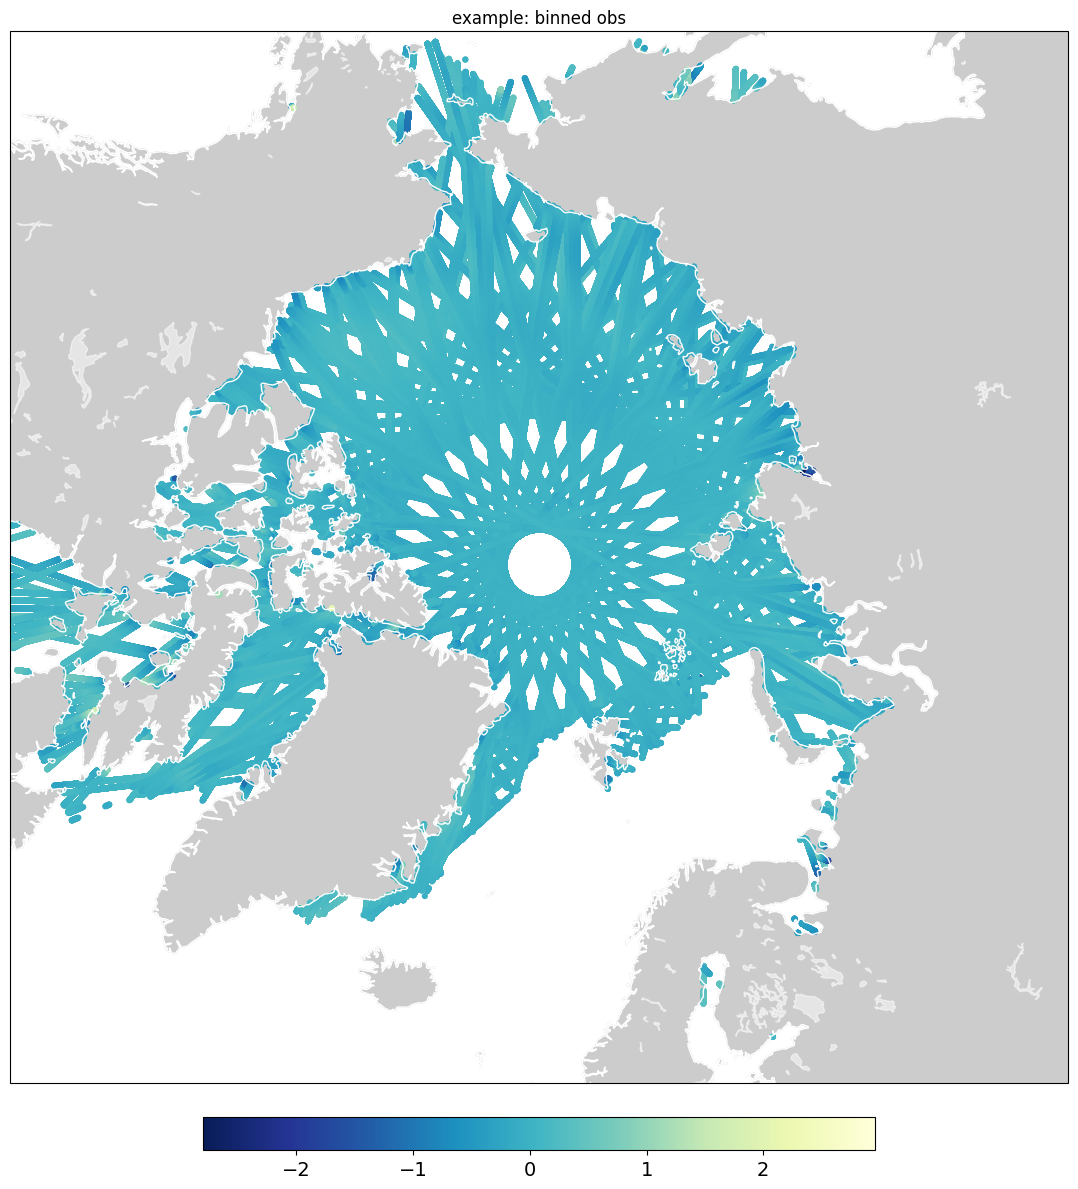

In [11]:
import re
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


all_data_df['lon'], all_data_df['lat'] = EASE2toWGS84(all_data_df['x'], all_data_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=all_data_df['lon'],
                lat=all_data_df['lat'],
                plot_data=all_data_df['SLA'],
                title="example: binned obs",
                scatter=True,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd

# Assuming df is already defined and contains the data
columns_to_extract = {
    'x': 'x',
    'y': 'y',
    't': 't',
    'SLA': 'z'
}
df = all_data_df[list(columns_to_extract.keys())].rename(columns=columns_to_extract)

# Check the first few rows to confirm the data was loaded correctly
print(df.head())



              x             y            t       z
1 -3.055943e+06 -1.270243e+06  11190.68184  0.4207
2 -3.055707e+06 -1.270022e+06  11190.68184  0.4201
3 -3.055472e+06 -1.269801e+06  11190.68184  0.4195
4 -3.055236e+06 -1.269580e+06  11190.68184  0.4190
5 -3.055000e+06 -1.269359e+06  11190.68184  0.4184


## Define variables and settings for GPSat

In [14]:
# lat,lon center (origin) used for converting between WGS84 and EASE2 projections
lat_0 = 90
lon_0 = 0

# expert location parameters
# spacing between experts (laid out on a grid), in meters
expert_spacing = 200_000
# range of experts, from origin, in meters
# expert_x_range = [-750_000.0, 1000_000.0]
# expert_y_range = [-500_000.0, 1250_000.0]
expert_x_range = [-3100_000, 3100_000]
expert_y_range = [-3100_000, 3100_000]

# prediction spacing
# (below predictions same range as experts)
pred_spacing = 5_000


# model parameters
# Set training and inference radius
# - distance observations need to be away from expert locations to be included in training
training_radius = 300_000  # 300km
# - distance prediction locations need to be away from expert locations in order of predictions to be made
inference_radius = 200_000  # 200km


# plotting
# extent = [lon min, lat max, lat min, lat max]
extent = [-180, 180, 60, 90]

# which projection to use: "north" or "south"
projection = "north"

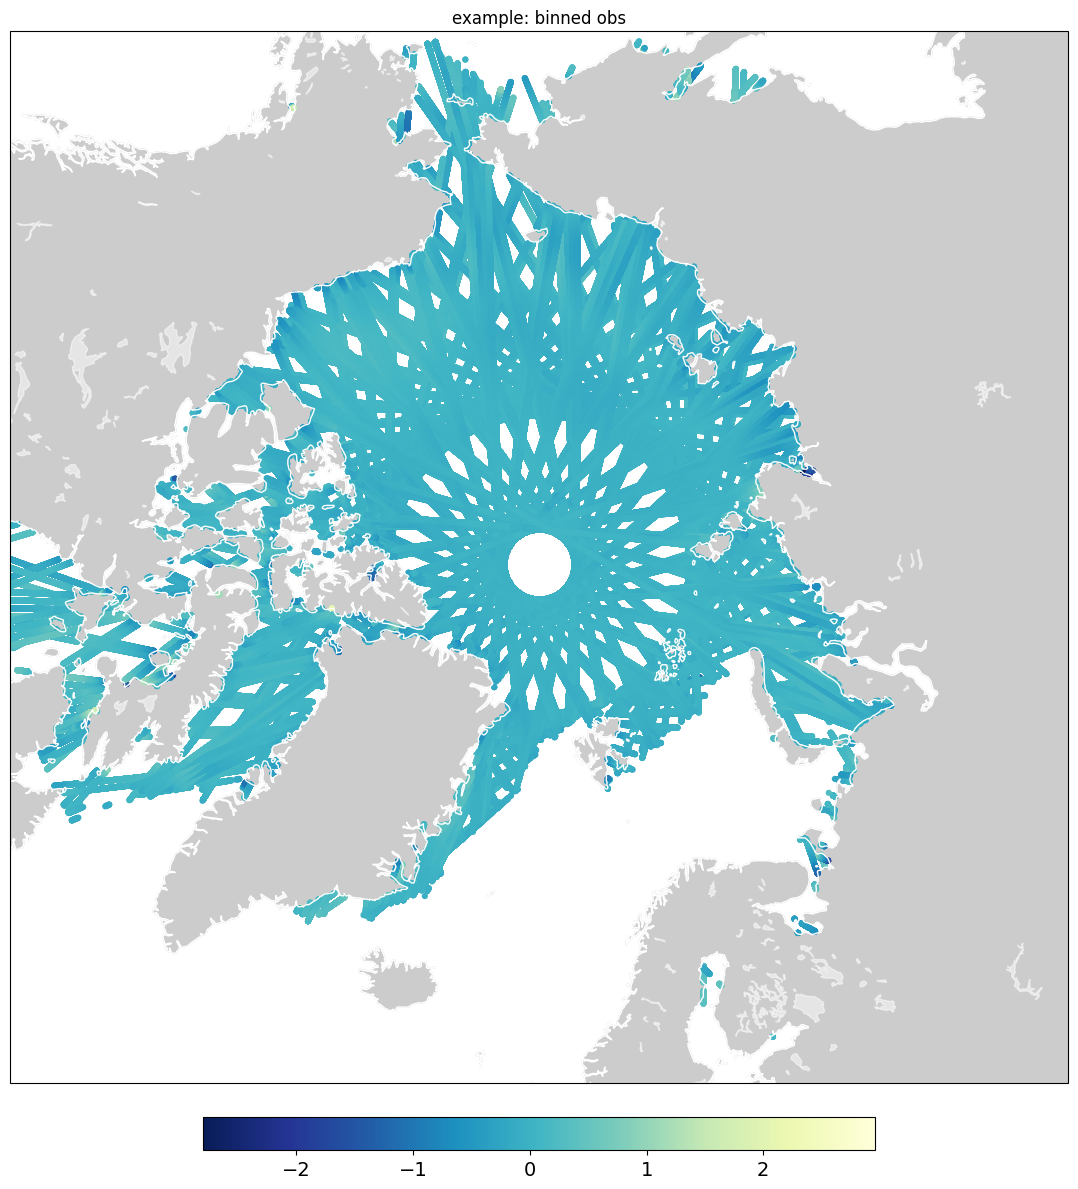

In [15]:
df['lon'], df['lat'] = EASE2toWGS84(df['x'], df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=df['lon'],
                lat=df['lat'],
                plot_data=df['z'],
                title="example: binned obs",
                scatter=True,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

In [16]:
xy_grid = grid_2d_flatten(x_range=expert_x_range,
                          y_range=expert_y_range,
                          step_size=expert_spacing)

# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())

print("Local expert locations:")
eloc.head()

Local expert locations:


x          y        t
0 -3000000.0 -3000000.0  11190.0
1 -2800000.0 -3000000.0  11190.0
2 -2600000.0 -3000000.0  11190.0
3 -2400000.0 -3000000.0  11190.0
4 -2200000.0 -3000000.0  11190.0

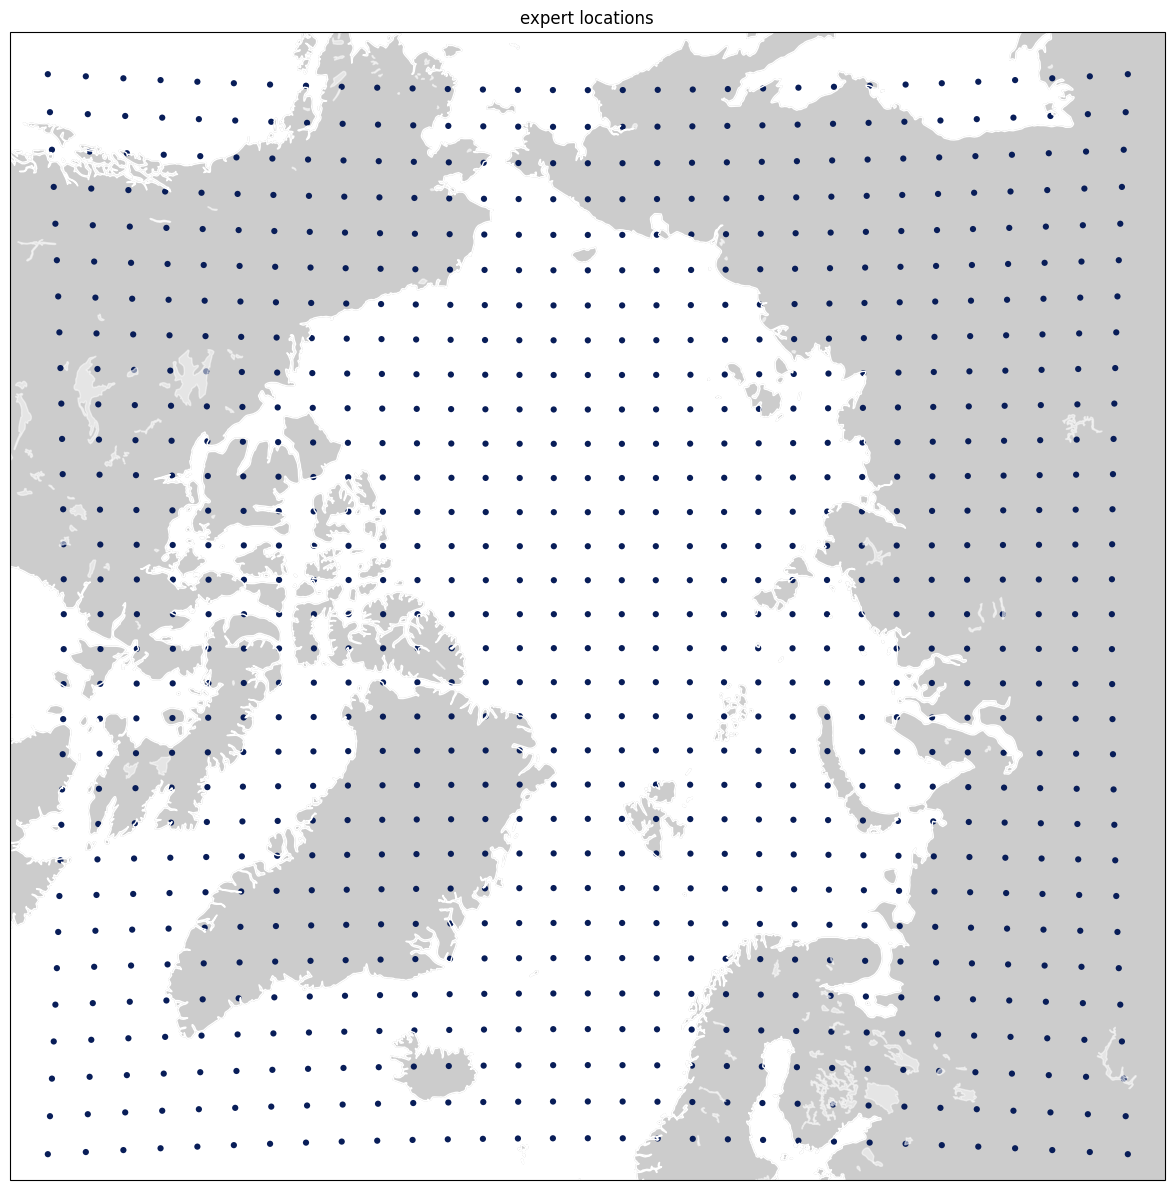

In [17]:
# plot expert locations
eloc['lon'], eloc['lat'] = EASE2toWGS84(eloc['x'], eloc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

In [18]:
from global_land_mask import globe
pred_xy_grid = grid_2d_flatten(x_range=expert_x_range,
                               y_range=expert_y_range,
                               step_size=pred_spacing)
# Load test locations
test_locs = pd.read_csv('/content/drive/MyDrive/PhD Year 1/GP_Appriximation/test_locs.csv')
# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
# ploc = pd.DataFrame(pred_xy_grid, columns=['x', 'y'])

# ploc['lon'], ploc['lat'] = EASE2toWGS84(ploc['x'], ploc['y'],
#                                         lat_0=lat_0, lon_0=lon_0)
ploc = test_locs
# identify if a position is in the ocean (water) or not
ploc["is_in_ocean"] = globe.is_ocean(ploc['lat'], ploc['lon'])

# keep only prediction locations in ocean
ploc = ploc.loc[ploc["is_in_ocean"]]

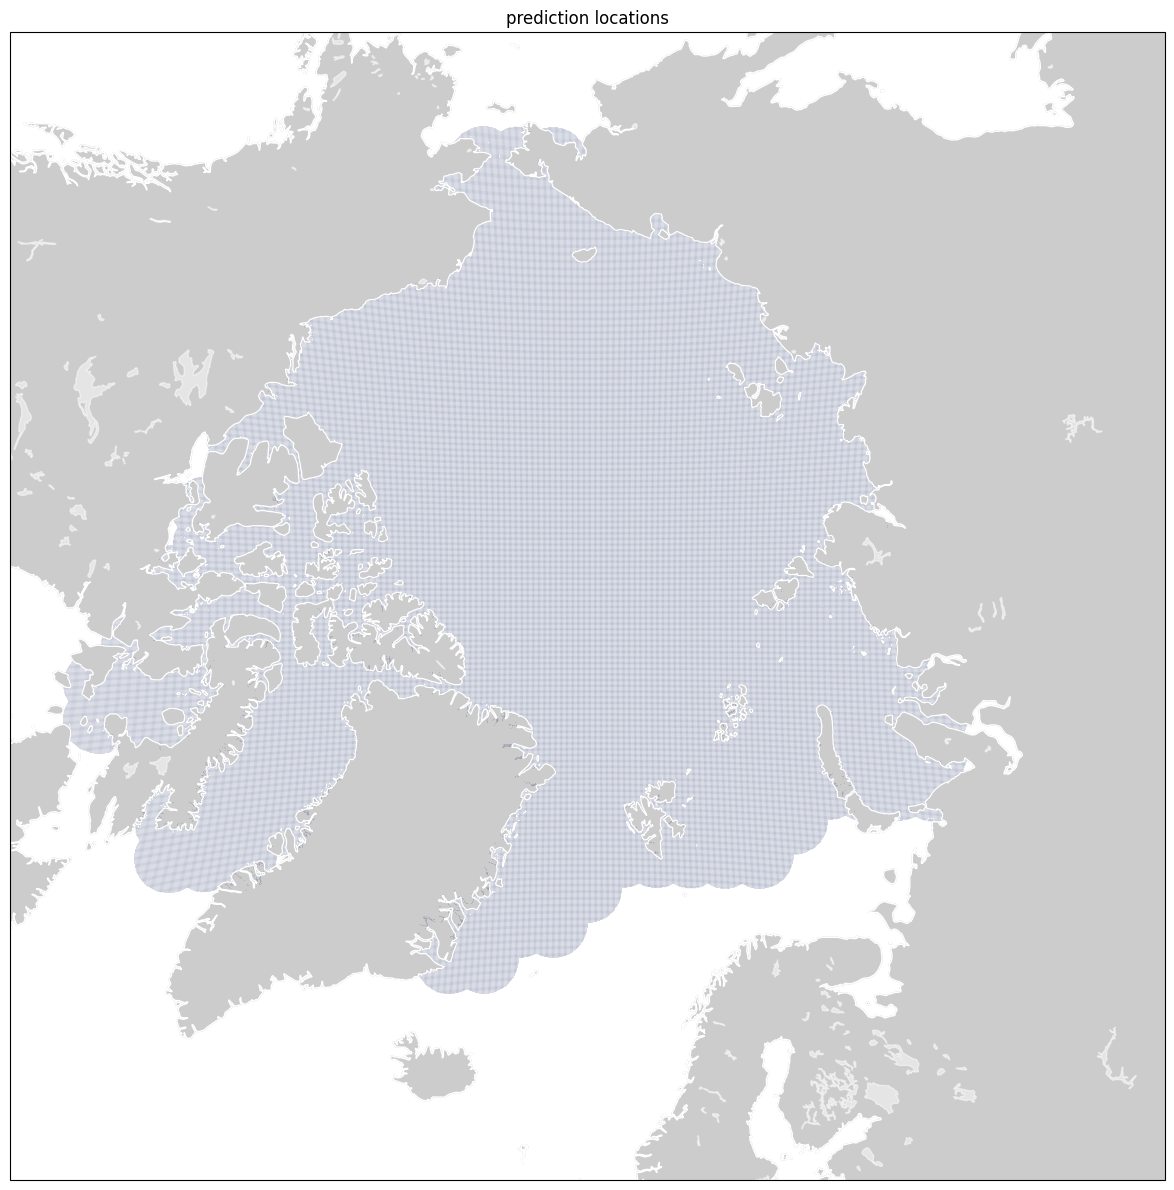

In [19]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=np.full(len(ploc), 1.0), #np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()


In [20]:
bin_ds = DataPrep.bin_data_by(df=df.loc[(df['z'] > -0.35) & (df['z'] < 0.65)],
                              by_cols=['t'],
                              val_col='z',
                              x_col='x',
                              y_col='y',
                              grid_res=50_000,
                              x_range=[-4500000.0, 4500000.0],
                              y_range=[-4500000.0, 4500000.0])

# convert bin data to DataFrame
# - removing all the nans that would be added at grid locations away from data
bin_df = bin_ds.to_dataframe().dropna().reset_index()

bin_df.head()

'bin_data_by': 1.088 seconds


y          x             t         z
0 -2925000.0  1425000.0  11190.681933  0.123950
1 -2925000.0  1475000.0  11190.681933  0.149100
2 -2725000.0  1025000.0  11190.681921  0.451891
3 -2675000.0  1025000.0  11190.681921  0.414517
4 -2625000.0  1025000.0  11190.681921  0.377294

In [54]:
bin_df.shape

(15801, 4)

<ipython-input-21-983b1d6bc006>:2: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  bin_df['lon'], bin_df['lat'] = EASE2toWGS84_New(bin_df['x'], bin_df['y'])


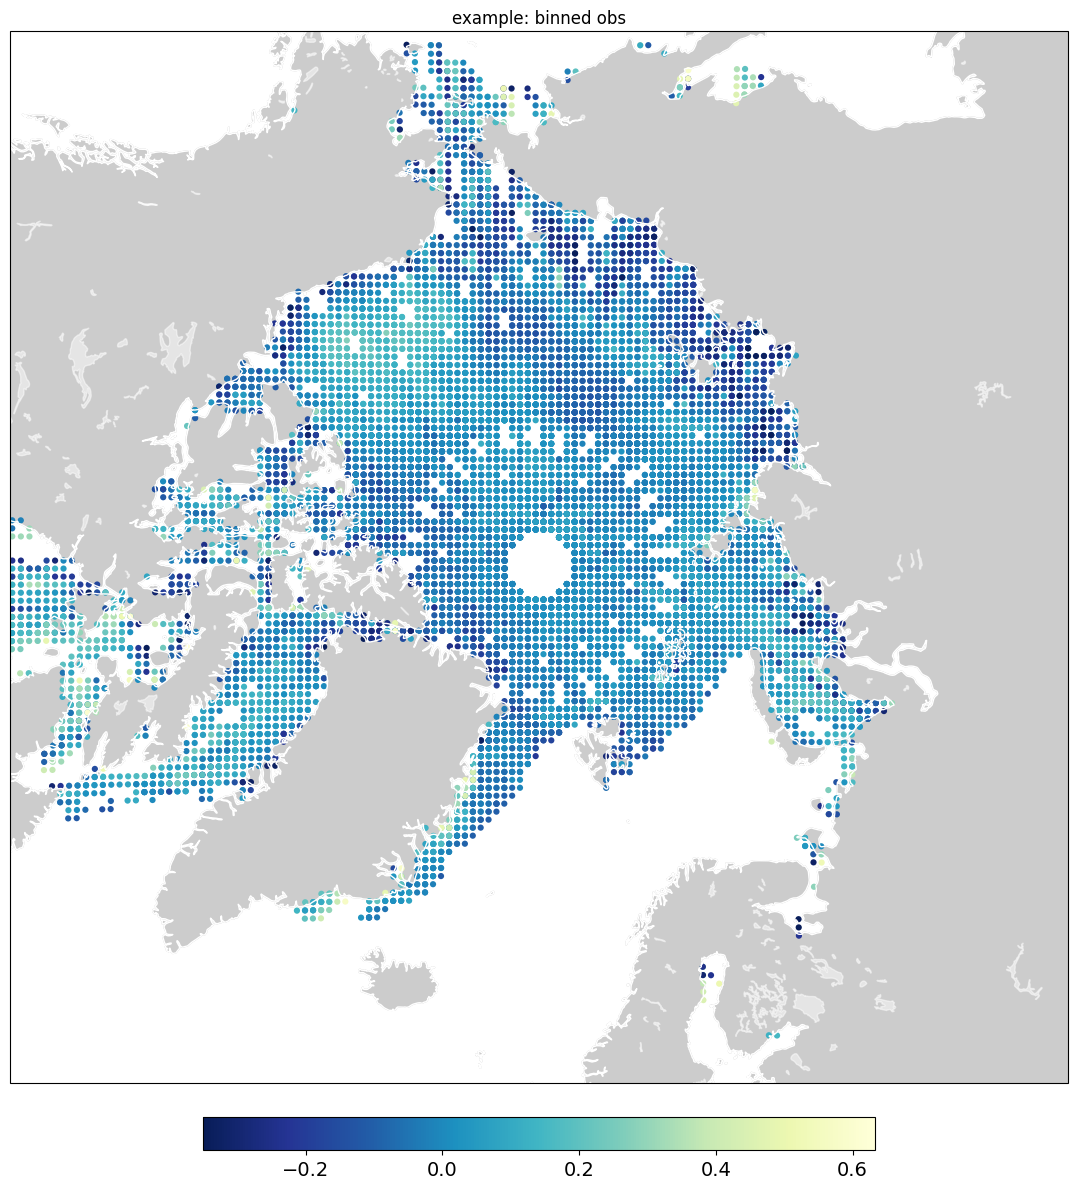

In [21]:
# this will plot all observations, some on top of each other
bin_df['lon'], bin_df['lat'] = EASE2toWGS84_New(bin_df['x'], bin_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=bin_df['lon'],
                lat=bin_df['lat'],
                plot_data=bin_df['z'],
                title="example: binned obs",
                scatter=True,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

In [22]:
# observation data
data = {
    "data_source": bin_df,
    "obs_col": "z",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert
    "local_select": [
        {
            "col": "t",
            "comp": "<=",
            "val": 4
        },
        {
            "col": "t",
            "comp": ">=",
            "val": -4
        },
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<",
            "val": training_radius
        }
    ]
}

# local expert locations
local_expert = {
    "source": eloc
}

# model
model = {
    "oi_model": "GPflowGPRModel",
    "init_params": {
        # scale (divide) coordinates
        "coords_scale": [50000, 50000, 1],
        # "num_inducing_points": 1000
        # can specify initial parameters values for model:
        # "noise_variance": 0.10,
        # "kernel_kwargs": {
        #     "lengthscales": [2.0, 2.0, 1.0],
        #     "variance": 0.05
        # }
    },
    # keyword arguments to be passed into each model/local expert's optimise_parameters method
    "optim_kwargs": {
        # parameters to be fixed (not trainable)
        # "fixed_params": ["likelihood_variance"]
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)
        # - given in unscaled units
        "lengthscales": {
            "low": [1e-08, 1e-08, 1e-08],
            "high": [600000, 600000, 9]
        },
        "likelihood_variance": {
            "low": 0.00125,
            "high": 0.01
        }
    }
}

# prediction locations
pred_loc = {
    "method": "from_dataframe",
    "df": ploc,
    "max_dist": inference_radius
}

## Train GPSat model and plotting

In [23]:
locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)

# run optimal interpolation
# - no predictions locations supplied
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}", "FAIL")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path,
           optimise=True,
           check_config_compatible=False)

流式输出内容被截断，只能显示最后 5000 行内容。
current local expert:
            x         y        t    lon        lat
570 -600000.0  600000.0  11190.0 -135.0  82.397073
'local_data_select': 0.006 seconds
number obs: 491
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.039 seconds
'set_lengthscales_constraints': 0.013 seconds
'set_likelihood_variance_constraints': 0.039 seconds
'optimise_parameters': 1.014 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([11.99993076, 11.99956346,  0.98577872]) 
kernel_variance: 0.004963885079095464
likelihood_variance: 0.0016327246970720985
'predict': 0.118 seconds
total run time : 2.08 seconds
--------------------------------------------------
572 / 961
current local expert:
            x         y        t         lon        lat
571 -400000.0  600000.0  11190.0 -146.309932  83.540179
'local_data_select': 0.007 seconds
number obs: 443
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.040 seconds
'set_lengthscales_constraints'

In [25]:
# extract, store in dict
dfs, oi_config = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")

reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details']


In [26]:
preds_data = dfs["preds"]

preds_data.head()

x          y        t  _dim_0        f*    f*_var     y_var  f_bar  \
0 -1000000.0 -2200000.0  11190.0       0  0.142743  0.023167  0.033167      0   
1 -1000000.0 -2200000.0  11190.0       1  0.147277  0.023288  0.033288      0   
2 -1000000.0 -2200000.0  11190.0       2  0.126710  0.022918  0.032918      0   
3 -1000000.0 -2200000.0  11190.0       3  0.132887  0.023009  0.033009      0   
4 -1000000.0 -2200000.0  11190.0       4  0.138279  0.023110  0.033110      0   

   pred_loc_x  pred_loc_y  pred_loc_t        lon        lat  
0   -977500.0  -2087500.0     11190.0 -24.443955  68.223016  
1   -977500.0  -2082500.0     11190.0 -24.443955  68.223016  
2   -972500.0  -2097500.0     11190.0 -24.443955  68.223016  
3   -972500.0  -2092500.0     11190.0 -24.443955  68.223016  
4   -972500.0  -2087500.0     11190.0 -24.443955  68.223016

In [27]:
# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.

plt_data = glue_local_predictions_2d(preds_df=preds_data,
                                     pred_loc_cols=["pred_loc_x", "pred_loc_y"],
                                     xprt_loc_cols=["x", "y"],
                                     vars_to_glue=["f*", "f*_var"],
                                     inference_radius=inference_radius)

plt_data.head()

pred_loc_x  pred_loc_y        f*    f*_var
0  -2997500.0   -627500.0  0.150485  0.016729
1  -2997500.0   -622500.0  0.152437  0.016715
2  -2997500.0   -617500.0  0.154354  0.016707
3  -2997500.0   -612500.0  0.156265  0.016702
4  -2997500.0   -607500.0  0.158189  0.016699

<ipython-input-25-f45ee14f26f4>:1: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  plt_data['lon'], plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'], plt_data['pred_loc_y'])


'data_select': 0.014 seconds
'load': 0.015 seconds
'plot_pcolormesh': 0.644 seconds


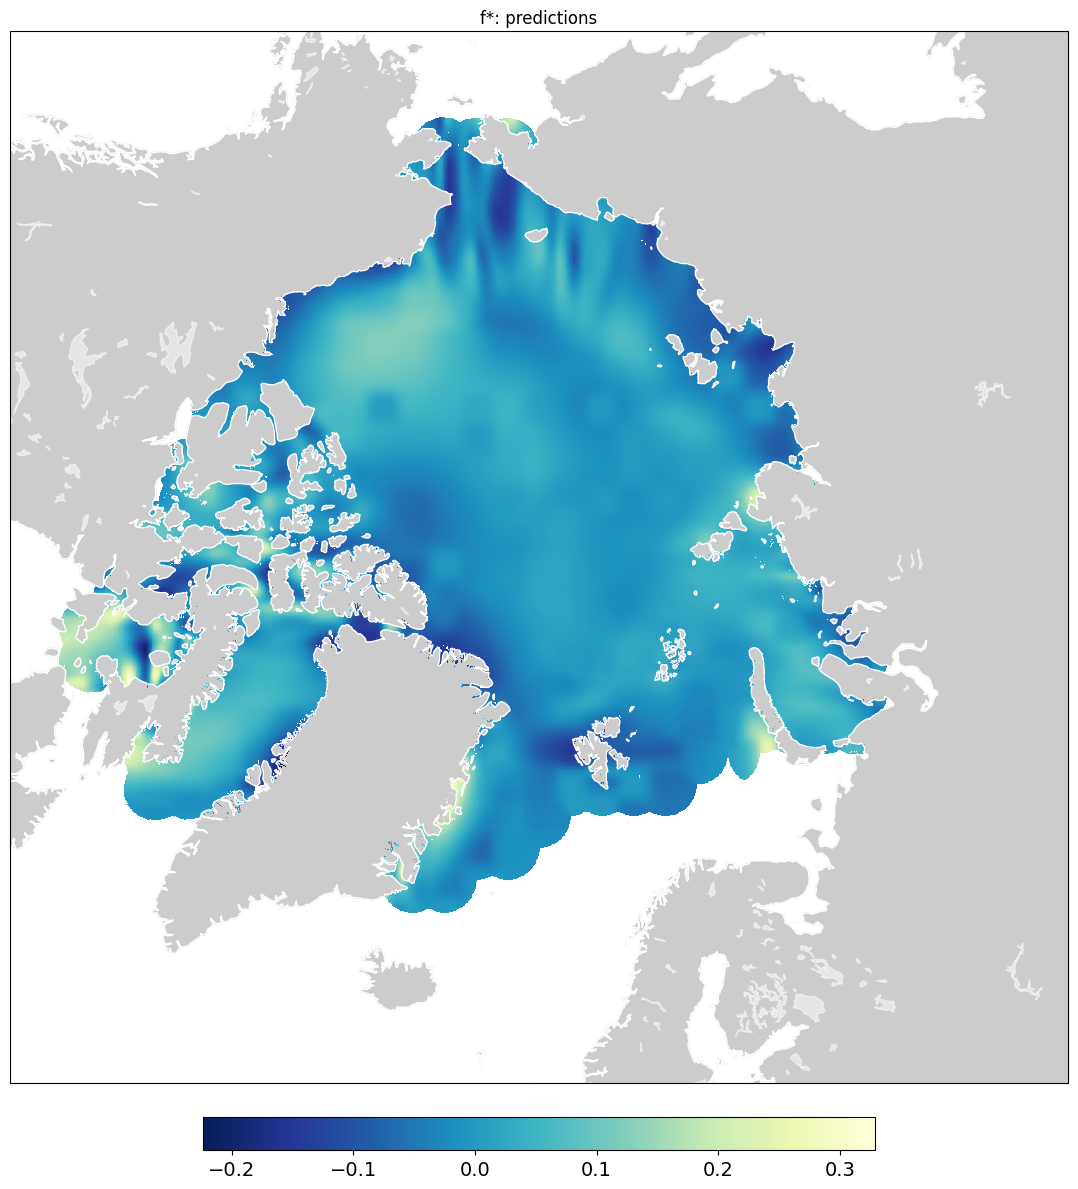

In [25]:
plt_data['lon'], plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'], plt_data['pred_loc_y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))
plot_pcolormesh_from_results_data(ax=ax,
                                  dfs={"preds": plt_data},
                                  table='preds',
                                  val_col="f*",
                                  scatter=False,
                                  x_col='pred_loc_x',
                                  y_col='pred_loc_y',
                                  fig=fig,
                                  plot_kwargs={"title": "f*: predictions"})
plt.tight_layout()
plt.show()